## Review (3)

Now everything is cool, so I'm just accepting your project. Good luck with future learning.

---

## Review (2)

Two of three issues are closed, but we still need to work with rounding of minutes and traffic. You did it in fair way :) but mobile operators prefer to round everything up :). I left you a comment inside the notebook with some extra explanation.

---

## Review

Hi Vladimir. My name is Soslan. I'm reviewing your work. I've added all my comments to new cells with the title "Review". My apologies for the delay in the review. We will be faster next time :)

```diff
+ If you did something great I'm using green color for my comment
- If the topic requires some extra work so I can accept it then the color will be red.
```

You did most of the work. Your code is very good quality and works correctly. But you need a bit more work with textual content and conclusions. Can you please look through my comments and work with them so I could accept your work. Good luck.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
import re
from scipy import stats as stats
from scipy.stats import f as f_test
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')

# Open the data file and study the general information

<div class="paragraph">You work as an analyst for "Megaline", a state mobile operator. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department would like to know which of the plans is more profitable in order to adjust the advertising budget. </div><div class="paragraph">You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 "Megaline" clients, specifically, who the clients are, where they are from, which plan they use, the number of calls made and SMS they sent in 2018. You have to analyse clients' behavior and work out the most profitable prepaid plan. </div><h3>Prepaid plans description</h3><div class="paragraph"><strong>Surf</strong></div>

<ol start="1"><li>Monthly charge: \$20</li><li>500 monthly minutes, 50 SMS and 15 GB of web traffic</li><li>After exceeding the package limits:
 1. 1 minute: 3 cents ("Megaline" always rounds up the minute and megabyte values. If the call lasted just one second, it will be counted as one minute);
 2. SMS: 3 cents;
 3. 1 GB of web traffic: \$10.</li></ol><div class="paragraph"><strong>Ultimate</strong></div><ol start="1"><li>Monthly charge: $70</li><li>3000 monthly minutes, 1000 SMS and 30 GB of web traffic</li><li>After exceeding the package limits:
 1. 1 minute: 1 cent;
 2. SMS: 1 cent;
 3. 1 GB of web traffic: \$7.</li></ol>


<div class="markdown markdown_size_normal markdown_type_theory"><h2><strong>Project description</strong></h2><h3>Data description</h3><div class="paragraph">The <code class="code-inline code-inline_theme_light">users</code> table (data on users):</div><ul><li><em>user_id</em> — unique user identifier</li><li><em>first_name</em> — user's name</li><li><em>last_name</em> — user's last name</li><li><em>age</em> — user's age (years)</li><li><em>reg_date</em> — subscription date (dd, mm, yy)</li><li><em>churn_date</em> — the date of use discontinue (if the value is missed, the calling plan was used at the moment of data extraction)</li><li><em>city</em> — user's city of residence</li><li><em>tarif</em> — calling plan name</li></ul><div class="paragraph">The <code class="code-inline code-inline_theme_light">calls</code> table (data on calls):</div><ul><li><em>id</em> — unique call identifier</li><li><em>call_date</em> — call date</li><li><em>duration</em> — call duration in minutes</li><li><em>user_id</em> — the identifier of the user making a call</li></ul><div class="paragraph">The <code class="code-inline code-inline_theme_light">messages</code> table (data on SMS):</div><ul><li><em>id</em> — unique SMS identifier</li><li><em>message_date</em> — SMS date</li><li><em>user_id</em> — the identifier of the user sending an SMS</li></ul><div class="paragraph">The <code class="code-inline code-inline_theme_light">internet</code> table (data on web sessions):</div><ul><li><em>id</em> — unique session id</li><li><em>mb_used</em> —  the volume of web traffic spent during a session (in megabytes)</li><li><em>session_date</em> — web session date</li><li><em>user_id</em> — user identifier</li></ul><div class="paragraph">The <code class="code-inline code-inline_theme_light">tariffs</code> table (data on the plans):</div><ul><li><em>tariff_name</em> — calling plan name</li><li><em>rub_monthly_fee</em> — monthly charge in rubles</li><li><em>minutes_included</em> — monthly minutes within package limits</li><li><em>messages_included</em> — monthly SMS within package limits</li><li><em>mb_per_month_included</em> — web traffic volume within package limits (in megabytes)</li><li><em>rub_per_minute</em> — the price per minute after exceeding the package limits (e.g., if the package included 100 minutes, the 101st minute will be charged)</li><li><em>rub_per_message</em> — the price per SMS after exceeding the package limits</li><li><em>rub_per_gb</em> — the price per extra gigabyte of web traffic after exceeding the package limits (1 GB = 1024 megabytes)</li></ul></div>

In [0]:
host="https://code.s3.yandex.net/"

In [0]:
megaline_calls = pd.read_csv(host+"datasets/megaline_calls.csv")
megaline_internet = pd.read_csv(host+"datasets/megaline_internet.csv")
megaline_messages = pd.read_csv(host+"datasets/megaline_messages.csv")
megaline_tariffs = pd.read_csv(host+"datasets/megaline_tariffs.csv")
megaline_users = pd.read_csv(host+"datasets/megaline_users.csv")

In [0]:
megaline_datasets = {"megaline_calls":megaline_calls, "megaline_internet":megaline_internet, "megaline_messages":megaline_messages, "megaline_tariffs":megaline_tariffs, "megaline_users":megaline_users}

In [0]:
for name, ds in megaline_datasets.items():
    f"{name} {ds.shape}"

'megaline_calls (137735, 4)'

'megaline_internet (104825, 4)'

'megaline_messages (76051, 3)'

'megaline_tariffs (2, 8)'

'megaline_users (500, 8)'

In [0]:
for name, ds in megaline_datasets.items():
    f"{name}"
    ds.info()

'megaline_calls'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


'megaline_internet'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null object
mb_used         104825 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


'megaline_messages'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


'megaline_tariffs'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
usd_monthly_pay          2 non-null int64
usd_per_gb               2 non-null int64
usd_per_message          2 non-null float64
usd_per_minute           2 non-null float64
tariff_name              2 non-null object
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


'megaline_users'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
churn_date    34 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


# Prepare the data

<ul><li>Convert the data to the necessary types;</li><li>Find and remove the errors in the data.</li></ul><div class="paragraph">Explain what errors did you find and how did you remove them. 
Please note: quite a lot of calls have a duration of 0.0 minutes, a strong hint that there is a problem with the data and needs preprocessing. </div><div class="paragraph">For each user, find:</div><ul><li>the number of calls made and minutes spent per month;</li><li>the number of SMS sent per month;</li><li>the volume of web traffic per month;</li><li>the monthly profit from each of the users (subtract free package limit from the total number of calls, SMS and web traffic; multiply the result by the calling plan value; add monthly charge depending on the calling plan).</li></ul>

In [0]:
for name, ds in megaline_datasets.items():
    f"{name}"
    ds.sample(2)

'megaline_calls'

,id,user_id,call_date,duration
47141,1171_172,1171,2018-11-22,13.03
39758,1147_545,1147,2018-12-27,7.86


'megaline_internet'

,id,user_id,session_date,mb_used
81444,1381_123,1381,2018-11-02,529.58
70094,1328_53,1328,2018-08-14,307.07


'megaline_messages'

,id,user_id,message_date
36240,1241_44,1241,2018-12-28
36440,1242_112,1242,2018-12-18


'megaline_tariffs'

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,tariff_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


'megaline_users'

,user_id,first_name,last_name,age,city,reg_date,tariff,churn_date
215,1215,Adelle,Knapp,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-07-01,surf,NaN
94,1094,Walter,Petersen,54,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-10-30,surf,2018-12-12


As we some columns have object(str) type.Let's fix it, convert them

In [0]:
megaline_calls["call_date"] = pd.to_datetime(megaline_calls["call_date"], format='%Y-%m-%d')

In [0]:
megaline_internet["session_date"] = pd.to_datetime(megaline_internet["session_date"], format='%Y-%m-%d')

In [0]:
megaline_messages["message_date"] = pd.to_datetime(megaline_messages["message_date"], format='%Y-%m-%d')

In [0]:
megaline_users["reg_date"] = pd.to_datetime(megaline_users["reg_date"], format='%Y-%m-%d')

In [0]:
megaline_users["churn_date"] = pd.to_datetime(megaline_users["churn_date"], format='%Y-%m-%d')

In [0]:
def missing_values(df):
  df_nulls=pd.concat([df.dtypes, df.isna().sum(), df.isna().sum()/len(df)], axis=1)
  df_nulls.columns = ["type","count","missing_ratio"]
  df_nulls=df_nulls[df_nulls["count"]>0]
  df_nulls.sort_values(by="missing_ratio", ascending=False)
  return df_nulls

Let's check missing ratio of data in our datasets

In [0]:
for name, ds in megaline_datasets.items():
  print(name)
  missing_values(ds)

megaline_calls


,type,count,missing_ratio


megaline_internet


,type,count,missing_ratio


megaline_messages


,type,count,missing_ratio


megaline_tariffs


,type,count,missing_ratio


megaline_users


,type,count,missing_ratio
churn_date,datetime64[ns],466,0.932


churn_date — the date of use discontinue (if the value is missed, the calling plan was used at the moment of data extraction)


In [0]:
megaline_users.columns

Index(['user_id', 'first_name', 'last_name', 'age', 'city', 'reg_date',
       'tariff', 'churn_date'],
      dtype='object')

In [0]:
megaline_users.loc[megaline_users["churn_date"].isna(), "churn_date"] = pd.datetime.now().date()

In [0]:
megaline_users["churn_date"] = pd.to_datetime(megaline_users["churn_date"], format='%Y-%m-%d')

In [0]:
megaline_users["used_days"] = (megaline_users["churn_date"]-megaline_users["reg_date"]).dt.days

In [0]:
megaline_users = megaline_users.drop(["churn_date"], axis=1)

In [0]:
def describe_full(df):
    data_describe = df.describe().T
    df_numeric=df._get_numeric_data()
    dtype_df=df_numeric.dtypes
    data_describe['dtypes']=dtype_df
    data_null = df_numeric.isnull().sum()/len(df) * 100
    data_describe['Missing %']=data_null
    Cardinality=df_numeric.apply(pd.Series.nunique)
    data_describe['Cardinality']=Cardinality
    df_skew=df_numeric.skew(axis = 0, skipna = True) 
    data_describe['Skew']=df_skew
    return data_describe

In [0]:
for name, ds in megaline_datasets.items():
  print(name)
  describe_full(ds)

megaline_calls


,count,mean,std,min,25%,50%,75%,max,dtypes,Missing %,Cardinality,Skew
user_id,137735.0,1247.658046,139.416268,1000.0,1128.00,1247.00,1365.00,1499.0,int64,0.0,481,0.010325
duration,137735.0,6.745927,5.839241,0.0,1.29,5.98,10.69,37.6,float64,0.0,2802,0.693502


megaline_internet


,count,mean,std,min,25%,50%,75%,max,dtypes,Missing %,Cardinality,Skew
user_id,104825.0,1242.496361,142.053913,1000.0,1122.00,1236.00,1367.00,1499.00,int64,0.0,489,0.080268
mb_used,104825.0,366.713701,277.170542,0.0,136.08,343.98,554.61,1693.47,float64,0.0,57624,0.532269


megaline_messages


,count,mean,std,min,25%,50%,75%,max,dtypes,Missing %,Cardinality,Skew
user_id,76051.0,1245.972768,139.843635,1000.0,1123.0,1251.0,1362.0,1497.0,int64,0.0,402,0.042754


megaline_tariffs


,count,mean,std,min,25%,50%,75%,max,dtypes,Missing %,Cardinality,Skew
messages_included,2.0,525.00,671.751442,50.00,287.500,525.00,762.500,1000.00,int64,0.0,2,NaN
mb_per_month_included,2.0,23040.00,10861.160159,15360.00,19200.000,23040.00,26880.000,30720.00,int64,0.0,2,NaN
minutes_included,2.0,1750.00,1767.766953,500.00,1125.000,1750.00,2375.000,3000.00,int64,0.0,2,NaN
usd_monthly_pay,2.0,45.00,35.355339,20.00,32.500,45.00,57.500,70.00,int64,0.0,2,NaN
usd_per_gb,2.0,8.50,2.121320,7.00,7.750,8.50,9.250,10.00,int64,0.0,2,NaN
usd_per_message,2.0,0.02,0.014142,0.01,0.015,0.02,0.025,0.03,float64,0.0,2,NaN
usd_per_minute,2.0,0.02,0.014142,0.01,0.015,0.02,0.025,0.03,float64,0.0,2,NaN


megaline_users


,count,mean,std,min,25%,50%,75%,max,dtypes,Missing %,Cardinality,Skew
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0,int64,0.0,500,0.000000
age,500.0,45.486,16.972269,18.0,30.00,46.0,61.00,75.0,int64,0.0,58,0.040081
used_days,500.0,642.588,170.340277,7.0,571.25,672.5,761.00,854.0,int64,0.0,286,-1.677155


We have denormalized table, let's build table that could neatly fit for ours purpose

In [0]:
megaline_users_messages = megaline_users.merge(megaline_messages).rename({"message_id":"id"}, axis=1)

In [0]:
megaline_users_internet = megaline_users.merge(megaline_internet).rename({"session_id":"id"}, axis=1)

In [0]:
megaline_users_call = megaline_users.merge(megaline_calls).rename({"call_id":"id"}, axis=1)

In [0]:
megaline_users_messages['message_month'] = megaline_users_messages['message_date'].dt.month

In [0]:
megaline_users_internet['session_month'] = megaline_users_internet['session_date'].dt.month

In [0]:
megaline_users_call['call_month'] = megaline_users_call['call_date'].dt.month

In [0]:
megaline_users_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104825 entries, 0 to 104824
Data columns (total 12 columns):
user_id          104825 non-null int64
first_name       104825 non-null object
last_name        104825 non-null object
age              104825 non-null int64
city             104825 non-null object
reg_date         104825 non-null datetime64[ns]
tariff           104825 non-null object
used_days        104825 non-null int64
id               104825 non-null object
session_date     104825 non-null datetime64[ns]
mb_used          104825 non-null float64
session_month    104825 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(4), object(5)
memory usage: 10.4+ MB


In [0]:
megaline_users_internet["mb_used"] = megaline_users_internet["mb_used"].apply(np.ceil) 

In [0]:
len(megaline_users_internet["id"].unique()) == len(megaline_users_internet["id"].str.replace("_", "").astype(int).unique())

True

In [0]:
megaline_users_internet["id"] = megaline_users_internet["id"].str.replace("_", "").astype(int)

In [0]:
map_tariff = {'ultimate':0, 'surf':1}

In [0]:
megaline_users_internet.tariff = (megaline_users_internet.tariff == 'surf').astype(int)

In [0]:
megaline_users_call.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137735 entries, 0 to 137734
Data columns (total 12 columns):
user_id       137735 non-null int64
first_name    137735 non-null object
last_name     137735 non-null object
age           137735 non-null int64
city          137735 non-null object
reg_date      137735 non-null datetime64[ns]
tariff        137735 non-null object
used_days     137735 non-null int64
id            137735 non-null object
call_date     137735 non-null datetime64[ns]
duration      137735 non-null float64
call_month    137735 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(4), object(5)
memory usage: 13.7+ MB


In [0]:
megaline_users_call["duration"] = megaline_users_call["duration"].apply(np.ceil)

In [0]:
len(megaline_users_call["id"].unique()) == len(megaline_users_call["id"].str.replace("_", "").astype(int).unique())

True

In [0]:
megaline_users_call["id"] = megaline_users_call["id"].str.replace("_", "").astype(int)

In [0]:
megaline_users_call.tariff = (megaline_users_call.tariff == 'surf').astype(int)

In [0]:
megaline_users_messages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76051 entries, 0 to 76050
Data columns (total 11 columns):
user_id          76051 non-null int64
first_name       76051 non-null object
last_name        76051 non-null object
age              76051 non-null int64
city             76051 non-null object
reg_date         76051 non-null datetime64[ns]
tariff           76051 non-null object
used_days        76051 non-null int64
id               76051 non-null object
message_date     76051 non-null datetime64[ns]
message_month    76051 non-null int64
dtypes: datetime64[ns](2), int64(4), object(5)
memory usage: 7.0+ MB


As we see id has pattern of "number-number" , maybe we could convert it to numeric format,  but before it we need
to check of validity of removing of "-"

In [0]:
len(megaline_users_messages["id"].unique()) == len(megaline_users_messages["id"].str.replace("_", "").astype(int).unique())

True

In [0]:
megaline_users_messages["id"] = megaline_users_messages["id"].str.replace("_", "").astype(int)

In [0]:
megaline_users_messages.tariff = (megaline_users_messages.tariff == 'surf').astype(int)

In [0]:
megaline_users.tariff = (megaline_users.tariff == 'surf').astype(int)

In [0]:
megaline_datasets = {"megaline_users_messages":megaline_users_messages, "megaline_users_call":megaline_users_call, "megaline_users_internet":megaline_users_internet}

In [0]:
for name, ds in megaline_datasets.items():
  print(name)
  print(ds.duplicated().sum())

megaline_users_messages
0
megaline_users_call
0
megaline_users_internet
0


In [0]:
megaline_users_call_pivot = pd.DataFrame(megaline_users_call.pivot_table(index=['user_id', 'call_month'], values='duration', aggfunc=['count', 'sum'])).reset_index(drop=False)
megaline_users_call_pivot.columns = ['user_id', 'call_month', 'count_calls', 'total_duration']
megaline_users_call_pivot.sample(2)

,user_id,call_month,count_calls,total_duration
1690,1369,12,58,386.0
4,1001,11,64,426.0


As we know Megaline round up duration and internet:

## Review (2)

```diff
- If the tail of number is less then .5 method .round() rounds it to the lower int number and if more or equal then to higher. Here you should always round your numbers to a higher value. So if the customer used 1.3 mb for the session company charges him for 2 mb. Same for minutes. Here method np.ceil could help you.

- You are rounding your data after aggregating it by months but should do it by every session or call and only after then round the data.
```

Here an useful link about how it works: http://www.datasciencemadesimple.com/ceil-floor-dataframe-pandas-python-2/

---


>Thanks, added round up above, removed it from pivot tables

In [0]:
megaline_users_call_pivot.sample(2)

,user_id,call_month,count_calls,total_duration
158,1042,4,44,279.0
1901,1412,10,142,1020.0


In [0]:
megaline_users_messages_pivot = pd.DataFrame(megaline_users_messages.pivot_table(index=['user_id', 'message_month'], values='id', aggfunc=['count'])).reset_index(drop=False)
megaline_users_messages_pivot.columns = ['user_id', 'msg_month', 'count_msg']
megaline_users_messages_pivot.sample(2)

,user_id,msg_month,count_msg
759,1201,11,8
1305,1350,12,7


In [0]:
megaline_users_internet_pivot = pd.DataFrame(megaline_users_internet.pivot_table(index=['user_id', 'session_month'], values='mb_used', aggfunc='sum')).reset_index(drop=False)
megaline_users_internet_pivot.columns = ['user_id', 'session_month', 'total_mb']
megaline_users_internet_pivot.sample(2)

,user_id,session_month,total_mb
387,1081,6,18162.0
1268,1267,11,1470.0


In [0]:
megaline_agg_df = (megaline_users
  .join(megaline_users_call_pivot.groupby('user_id')[['total_duration', 'count_calls']].sum(), on='user_id')
  .join(megaline_users_internet_pivot.groupby('user_id')['total_mb'].sum(), on='user_id')
  .join(megaline_users_messages_pivot.groupby('user_id')['count_msg'].sum(), on='user_id'))

In [0]:
#kx+b=y, 500 when tariff is 1 and  3000 when is 0, we have -2500x+3000
megaline_agg_df['duration_left'] = megaline_agg_df["total_duration"] - (-2500*megaline_agg_df["tariff"] + 3000)

In [0]:
def calc_call_profit(r):
    duration = r['duration_left']
    tariff = 0.03 if r['tariff'] else 0.01
    return duration*tariff

In [0]:
megaline_agg_df['profit_call'] = megaline_agg_df.apply(calc_call_profit, axis=1)

In [0]:
megaline_agg_df['mb_left'] = megaline_agg_df["total_mb"] - (-15*1024*megaline_agg_df["tariff"]+30*1024)

In [0]:
def calc_internet_profit(r):
    internet = r['total_mb']/1024
    tariff = 10 if r['tariff'] else 7
    return internet*tariff

In [0]:
megaline_agg_df['profit_internet'] = megaline_agg_df.apply(calc_internet_profit, axis=1)

In [0]:
megaline_agg_df['msg_left'] = megaline_agg_df["count_msg"] - (-950*megaline_agg_df["tariff"] + 1000)

In [0]:
def calc_msg_profit(r):
    msg = r['msg_left']
    tariff = 0.03 if r['tariff'] else 0.01
    return msg*tariff

In [0]:
megaline_agg_df['profit_msg'] = megaline_agg_df.apply(calc_msg_profit, axis=1)

In [0]:
months = 12

In [0]:
megaline_agg_df['profit_total'] = (megaline_agg_df['profit_internet'] + megaline_agg_df['profit_call'] + megaline_agg_df['profit_msg']) +(-50*megaline_agg_df["tariff"]+70)

In [0]:
megaline_agg_df['duration_per_month'] = megaline_agg_df['total_duration'] / months
megaline_agg_df['calls_month'] = megaline_agg_df['count_calls'] / months
megaline_agg_df['internet_mb_per_month'] = megaline_agg_df['total_mb'] / months
megaline_agg_df['msg_per_month'] = megaline_agg_df['count_msg'] / months

In [0]:
megaline_agg_df['profit_per_month'] = megaline_agg_df['profit_total'] / months

In [0]:
megaline_agg_df.fillna(0)

,user_id,first_name,last_name,age,city,reg_date,tariff,used_days,total_duration,count_calls,...,mb_left,profit_internet,msg_left,profit_msg,profit_total,duration_per_month,calls_month,internet_mb_per_month,msg_per_month,profit_per_month
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,0,497,124.0,16.0,...,-28817.0,13.008789,-989.0,-9.89,44.358789,10.333333,1.333333,158.583333,0.916667,3.696566
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,1,630,1728.0,261.0,...,65180.0,786.523438,157.0,4.71,848.073438,144.000000,21.750000,6711.666667,17.250000,70.672786
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,1,561,829.0,113.0,...,24979.0,393.935547,38.0,1.14,424.945547,69.083333,9.416667,3361.583333,7.333333,35.412129
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,1,827,1104.0,149.0,...,11709.0,264.345703,0.0,0.00,302.465703,92.000000,12.416667,2255.750000,4.166667,25.205475
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,1,712,2772.0,370.0,...,141188.0,1528.789062,127.0,3.81,1620.759063,231.000000,30.833333,13045.666667,14.750000,135.063255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,1,608,1765.0,253.0,...,83650.0,966.894531,0.0,0.00,0.000000,147.083333,21.083333,8250.833333,0.000000,0.000000
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,1,804,1455.0,195.0,...,48997.0,628.486328,15.0,0.45,677.586328,121.250000,16.250000,5363.083333,5.416667,56.465527
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,0,511,300.0,54.0,...,-19600.0,76.015625,-950.0,-9.50,109.515625,25.000000,4.500000,926.666667,4.166667,9.126302
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,1,820,3211.0,451.0,...,212438.0,2224.589844,0.0,0.00,0.000000,267.583333,37.583333,18983.166667,0.000000,0.000000


### Summary

We had really low missed data, - only churn_date, but it's logically correct, cause on the extraction date users still use services. created new feature - used days, - count of days
in duration of that users used to services and column churn_date was dropped. Also datetimes columns was converted to demanded format. 
Also features were created for representing the month usage of services.

## Review

```diff
+ You did more than needed in this section, prepare a lot of new features this is great.
- You forgot to apply providers trick with rounding up minutes and megabytes ("Megaline" always rounds up the minute and megabyte values. If the call lasted just one second, it will be counted as one minute) can you also implement this :)
```

It is a bit hard to track your work as you leave few comments inside. Your variables names are great, but some accompanying text would be great.

>Thanks! I fixed it

# Analyse the data

<div class="paragraph">Describe the clients' behavior. For the users of each of the plans, find the number of minutes and SMS and the volume of web traffic they require per month. Calculate the mean, variance and standard deviation. Plot histograms. Describe the distributions. </div>

We are going to calculate this metrics:
call per month usage, internet per month usage, mb, messages per month usage, profit per month

In [0]:
metrics = {'calls_month':'call per month usage', 'internet_mb_per_month':'internet per month usage, mb', 'msg_per_month':'messages per month usage', 'profit_per_month':'profit per month'}

Let's create plot function, for comparing distribution of our metrics comparing for our plans

In [0]:
def generate_plots(df, metrics=metrics):
   ultimate = df[df["tariff"]==0]
   surf = df[df["tariff"]==1]
   for col, title in metrics.items():
     plt.hist(ultimate[col], alpha=0.5, label=f'ultimate {col}')
     plt.hist(surf[col], alpha=0.5, label=f'surf {col}')
     plt.legend(loc='upper right')
     plt.show()

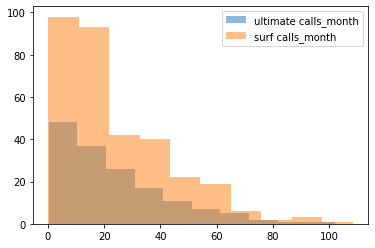

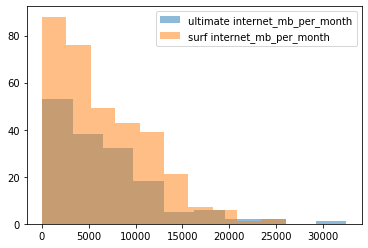

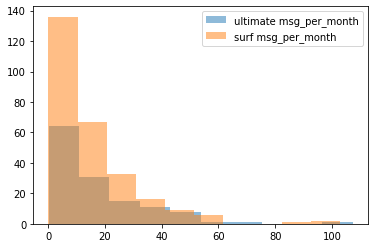

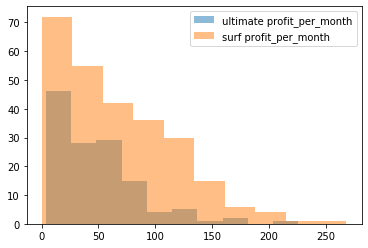

In [0]:
generate_plots(megaline_agg_df)

In [0]:
def generate_report(df, tariff_repr, metrics=metrics):
   print(f"{tariff_repr}") 
   tariff = 0 if tariff_repr == "ultimate" else 1
   dfq = df[df["tariff"]==tariff]
   funcs = {'average':np.mean, 'variance':np.var, 'std':np.std}
   for col, title in metrics.items():
     for method_name, func in funcs.items():
         print(f'{method_name} {title}: {func(dfq[col]):.2f}')


### Summary

In [0]:
generate_report(megaline_agg_df, 'ultimate')

ultimate
average call per month usage: 23.47
variance call per month usage: 392.62
std call per month usage: 19.81
average internet per month usage, mb: 6586.49
variance internet per month usage, mb: 30623278.51
std internet per month usage, mb: 5533.83
average messages per month usage: 17.07
variance messages per month usage: 279.27
std messages per month usage: 16.71
average profit per month: 47.96
variance profit per month: 1429.83
std profit per month: 37.81


In [0]:
generate_report(megaline_agg_df, 'surf')

surf
average call per month usage: 24.05
variance call per month usage: 393.28
std call per month usage: 19.83
average internet per month usage, mb: 6545.38
variance internet per month usage, mb: 24764678.40
std internet per month usage, mb: 4976.41
average messages per month usage: 15.13
variance messages per month usage: 243.26
std messages per month usage: 15.60
average profit per month: 67.31
variance profit per month: 2576.00
std profit per month: 50.75


## Review

```diff
+ Your code is great and compact. Everything works correctly
- Your work needs more textual content. Some explanations for people who don't understand code. What is happening, what is the results of your analysis, some insights. For example, I see that you calculated monthly profit for users, but I don't see anything about it in your reports.
```

>Fixed it, added some explanations;)!

# Test the hypotheses

<ul><li>the average profit from the users of Ultimate and Surf calling plans is different;</li><li>the average profit from the users in NY-NJ area is different from that of the users from other regions.</li></ul><div class="paragraph">Assign the threshold <em>alpha</em> value independently. </div><div class="paragraph">Explain:</div><ul><li>how you formulated the null and alternative hypotheses;</li><li>what criterion you used for testing the hypotheses and why.</li></ul>

##### Hypotheses is avg profit of two plans are not different (the null hypothesis that Var(X) == Var(Y))
We will use F-test



In [0]:
megaline_agg_df.columns

Index(['user_id', 'first_name', 'last_name', 'age', 'city', 'reg_date',
       'tariff', 'used_days', 'total_duration', 'count_calls', 'total_mb',
       'count_msg', 'duration_left', 'profit_call', 'mb_left',
       'profit_internet', 'msg_left', 'profit_msg', 'profit_total',
       'duration_per_month', 'calls_month', 'internet_mb_per_month',
       'msg_per_month', 'profit_per_month'],
      dtype='object')

In [0]:
ultimate = megaline_agg_df[megaline_agg_df["tariff"] == 0]['profit_per_month'].dropna()
surf = megaline_agg_df[megaline_agg_df["tariff"] == 1]['profit_per_month'].dropna()

In [0]:
def check_f_test(X,Y):
  F = np.var(X) / np.var(Y)
  p_value = f_test.cdf(F, len(X)-1, len(Y)-1)
  return p_value > .05

In [0]:
if check_f_test(ultimate, surf):
    print('could not reject the null hypothesis, therefore that Var(ultimate) == Var(surf)')
else:
    print('There is significance to reject the null hypothesis, therefore Var(ultimate) != Var(surf)')

There is significance to reject the null hypothesis, therefore Var(ultimate) != Var(surf)


In [0]:
results = stats.ttest_ind(ultimate, surf, equal_var=True)
print(results.pvalue)
if results.pvalue < .05:
      print('reject the null hypothesis, therefore the average profits for plans are different')
else:
      print('Fail in rejecting of the null hypothesis, therefore the average profits for plans are the same')

0.000137201929044172
reject the null hypothesis, therefore the average profits for plans are different


The average profit from the users of Ultimate and Surf calling plans is different;

Let's handle with NY areay, first of all we need to ckeck all unique value, find the pattern for detection of area

In [0]:
megaline_agg_df["city"].unique()
# "NY-NJ"

array(['Atlanta-Sandy Springs-Roswell, GA MSA',
       'Seattle-Tacoma-Bellevue, WA MSA',
       'Las Vegas-Henderson-Paradise, NV MSA', 'Tulsa, OK MSA',
       'Dallas-Fort Worth-Arlington, TX MSA',
       'San Francisco-Oakland-Berkeley, CA MSA',
       'Grand Rapids-Kentwood, MI MSA',
       'Orlando-Kissimmee-Sanford, FL MSA',
       'San Jose-Sunnyvale-Santa Clara, CA MSA',
       'Cleveland-Elyria, OH MSA',
       'Chicago-Naperville-Elgin, IL-IN-WI MSA', 'Knoxville, TN MSA',
       'New York-Newark-Jersey City, NY-NJ-PA MSA', 'Pittsburgh, PA MSA',
       'Fresno, CA MSA',
       'Washington-Arlington-Alexandria, DC-VA-MD-WV MSA',
       'Indianapolis-Carmel-Anderson, IN MSA', 'Jacksonville, FL MSA',
       'Los Angeles-Long Beach-Anaheim, CA MSA',
       'Omaha-Council Bluffs, NE-IA MSA',
       'Houston-The Woodlands-Sugar Land, TX MSA',
       'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA',
       'Tampa-St. Petersburg-Clearwater, FL MSA',
       'Birmingham-Hoover, AL MSA'

In [0]:
megaline_agg_df["is_NY"] = megaline_agg_df["city"].str.contains("NY-NJ")

In [0]:
NY = megaline_agg_df[megaline_agg_df["is_NY"]]['profit_per_month'].dropna()
not_NY = NY = megaline_agg_df[~megaline_agg_df["is_NY"]]['profit_per_month'].dropna()

In [0]:
if check_f_test(NY, not_NY):
    print('There is significance to reject the null hypothesis, therefore Var(ultimate) == Var(surf)')   
else:
    print('Failed to reject the null hypothesis, therefore Var(ultimate) != Var(surf)')
    

There is significance to reject the null hypothesis, therefore Var(ultimate) == Var(surf)


In [0]:
results = stats.ttest_ind(NY, not_NY, equal_var=True)
if results.pvalue < .05:
      print('we have sufficient significance for rejecting the null hypothesis, therefore the avg profits comparing for two population in NY area or not are different')
        
else:
      print('Fail in rejecting of the null hypothesis, therefore the avg profits comparing for two population in NY area or not are the same')

Fail in rejecting of the null hypothesis, therefore the avg profits comparing for two population in NY area or not are the same


# Write an overall conclusion

<div class="paragraph"><strong>Format:</strong> Complete the task in <em>Jupyter Notebook</em>. Insert the programming code in <em>code</em> cells and text explanations in <em>markdown</em> cells then apply formatting and headings.</div>

## Summary

In [0]:
We checked ultimate and surf plans

Checked data, some statistics, also dists for some total features were checked

Also were checked  null hypotesis: average profit of the ultimate plan and the surf plan is the same, (significance level is 0.05)

The same check we did for NY-NJ clients and other regions


In [0]:
## Review

```diff
- And again, code is great, but your conclusions contradict to your code. In the case of different tariffs you reject the null hypothesis, and in the case of different areas - not. But you copypaste your code and don't change text second time so in the overall conclusion, you mess results of your tests.
```

>I apologise for that! I added notes, yes I duplicated code, bit didn't correct it after(

In [0]:
## Review (2)

```diff
+ In two last section everything is correct now, thanks.
```

---